# Graph Tool Sanbox

In [80]:
# Mathematical and Data Managment
import numpy as np
import pandas as pd
import scipy.sparse as sp

# Graph Managment
import graph_tool.all as gt
import networkx as nx
import Functions as Fun
import Segregation as Seg
 
# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from forceatlas2 import forceatlas2_networkx_layout

# Miscellaneous
from glob import glob
from tqdm import tqdm
import random

# Reload Utils
import importlib
importlib.reload(Seg)
importlib.reload(Fun)


<module 'Functions' from '/mnt/disk2/fcastrillon/Analysis-of-Tweets-During-the-2021-Social-Unrest/Code/Functions.py'>

Grafo Minimo reproducible similar al grafo grande

This is our toy edge list [(0, 1), (1, 2), (2, 0), (3, 1), (4, 5), (5, 4)]
This are our toy weights [8, 9, 7, 10, 12, 11]


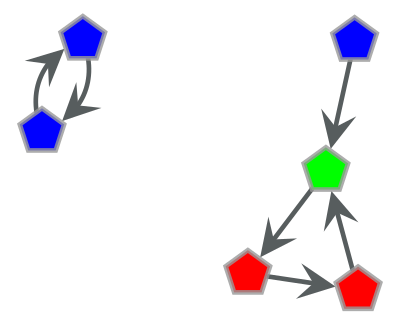

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fde26d1a6d0, at 0x7fde08f46290>

In [72]:
# TOY GRAPH FOR CALCULATIONS
random.seed(1)

edge_list = [(0,1),(1,2),(2,0),(3,1),(4,5),(5,4)]
vertex_dict = {
    'label': 'a b c d e f'.split(' '),
    'pa': 'd c d i i i'.split(' '),
    'id': [i for i in range(10000,10006)]
}
color = {
    'i': (0,0,1), # Azul
    'd': (1,0,0), # Rojo
    'c': (0,1,0) # Centro
}
weights = [8,9,7,10,12,11]
g = gt.Graph(directed=True)
print(f'This is our toy edge list {edge_list}')
print(f'This are our toy weights {weights}')

g.add_edge_list(edge_list=edge_list)

# Create an edge property map for weights
edge_weight_map = g.new_edge_property("double")
edge_date_map = g.new_edge_property('string')

# Create a Vertex property map for labels
vertex_PA_map = g.new_vertex_property('string')
vertex_ID_map = g.new_vertex_property('int64_t')
vertex_color_map = g.new_vertex_property('vector<double>')
vertex_label_map = g.new_vertex_property('string')
vertex_izquierda_map = g.new_vertex_property('bool')

# Add edges properties
edge_list = g.get_edges()
for i, e in enumerate(edge_list):
    edge_weight_map[e] = weights[i]
    edge_date_map[e] = '2021-05-16'

# Add Vertex properties
vertex_list = g.get_vertices()
for v in vertex_list:
    vertex_PA_map[v] = vertex_dict['pa'][v]
    vertex_ID_map[v] = vertex_dict['id'][v]
    vertex_label_map[v] = vertex_dict['label'][v]
    vertex_color_map[v] = color[vertex_dict['pa'][v]]
    if vertex_dict['pa'][v] == 'i':
        vertex_izquierda_map[v] = True
    else:
        vertex_izquierda_map[v] = False

# Assign the maps to the Graph Object
g.vp['Political Label'] = vertex_PA_map
g.vp['User ID'] = vertex_ID_map
g.vp['Label'] = vertex_label_map
g.vp['Color'] = vertex_color_map
g.vp['Izquierda'] = vertex_izquierda_map
g.ep['Normal Weights'] = edge_weight_map
g.ep['Ending date'] = edge_date_map

# Create a graph layout and drawing
pos = gt.sfdp_layout(g)

gt.graph_draw(g,
              pos=pos,
              output_size=(200, 200),
              vertex_fill_color=vertex_color_map, # Uncomment to show Vertex colors
              #vertex_text=vertex_label_map,        # Uncomment to show vertex labels
              vertex_shape = 'pentagon')

In [52]:
# FUNCTION TESTING
print('Adjacency Matrix (Can have weights or be simple 1-0)')
print(Fun.get_adjacency(g))
print(' ')
print('Nodes')
print(g.get_vertices())
print(' ')
print('Types Array')
print(Fun.get_types_array(g,types='Political Label'))
print(' ')
print('Types Dictionary')
print(Fun.get_types_dict(g,types='Political Label'))
print(' ')
print('Types Index Dictionary')
print(Fun.get_types_index(g,types='Political Label'))
print(' ')
print('Types Matrix (A column is one of the arrays in the Types Dictionary)')
print(Fun.get_types_matrix(g,types='Political Label'))
print(' ')
print('Contact Layer')
print(Fun.get_contact_layer(g,types='Political Label'))
print(' ')
print('Non Contact Layer')
print(Fun.get_non_contact_layer(g,types='Political Label'))
print(' ')
print('Me Vs Others (Contact Layer considering one group Against all others) for Derecha')
print(Fun.me_vs_others(Fun.get_contact_layer(g,types='Political Label'), Fun.get_types_index(g,types='Political Label')['d'] ))

Adjacency Matrix (Can have weights or be simple 1-0)
[[0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]]
 
Nodes
[0 1 2 3 4 5]
 
Types Array
['d' 'c' 'd' 'i' 'i' 'i']
 
Types Dictionary
{'c': [0, 1, 0, 0, 0, 0], 'd': [1, 0, 1, 0, 0, 0], 'i': [0, 0, 0, 1, 1, 1]}
 
Types Index Dictionary
{'c': 0, 'd': 1, 'i': 2}
 
Types Matrix (A column is one of the arrays in the Types Dictionary)
[[0 1 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [0 0 1]
 [0 0 1]]
 
Contact Layer
[[0. 1. 0.]
 [1. 1. 0.]
 [1. 0. 2.]]
 
Non Contact Layer
[[0. 1. 3.]
 [1. 1. 6.]
 [2. 6. 4.]]
 
Me Vs Others (Contact Layer considering one group Against all others) for Derecha
[[1. 1.]
 [1. 3.]]


In [83]:
Fun.get_contact_layer(g, 'Izquierda')

array([[2., 1.],
       [0., 3.]])

In [12]:
# Segregation Index =================================================================================
def ss_index(g:gt.Graph, type:str, weight:str):

    # Take subgraphs of b-nodes
    sub = gt.GraphView(g, vfilt=g.vp[type])

    # Label components
    components_map = gt.label_components(sub)[0]
    comps = np.unique(components_map.a)
    
    component_subgraphs = [gt.GraphView(sub, vfilt=lambda v: components_map[v] == comp) for comp in comps]

    # Compute eigen-decomposition
    e = [gt.eigenvector(g, weight=g.ep[weight], max_iter=10) for g in component_subgraphs]

    # # Component SSIs (largest eigenvalue)
    # cssi = [float(x.a[0]) for x in e]

    # # Eigenvectors of the largest eigenvalue
    # ev = [list(x.get_array()) for x in e]

    # issi = {}
    # for i, component in enumerate(gt.component_subgraphs(sub, comps)):
    #     rval = cssi[i] * ev[i] / ev[i].mean()
    #     for v in component.iter_vertices():
    #         issi[g.vp.id[v]] = rval[int(v)]
    
    # # Sort issi by node id
    # issi = dict(sorted(issi.items(), key=lambda item: int(item[0])))

    # # Create output
    # issi_ids = {'id': list(issi.keys()), 'outcome': list(issi.values())}

    # eturn issi_ids
    return e

XD = ss_index(g, 'Izquierda', 'Normal Weights')

In [18]:
XD[1]

(11.46742720894503,
 <VertexPropertyMap object with value type 'double', for Graph 0x7f1b8a4a0a90, at 0x7f1b89343d50>)

In [10]:
gt.graph_draw(XD[0],
              pos=pos,
              output_size=(200, 200),
              vertex_fill_color=vertex_color_map, # Uncomment to show Vertex colors
              #vertex_text=vertex_label_map,        # Uncomment to show vertex labels
              vertex_shape = 'pentagon')

AttributeError: 'float' object has no attribute 'own_property'

In [19]:
g_view = gt.GraphView(g, vfilt=g.vp['Izquierda'])

In [8]:
gt.eigenvector(g, weight=g.ep['Normal Weights'], max_iter=100000)

(11.467427208945033,
 <VertexPropertyMap object with value type 'double', for Graph 0x7fde0a615250, at 0x7fde0af72b10>)

In [12]:
gt.eigenvector(g, weight=g.ep['Normal Weights'], max_iter=100000)[1].a

PropertyArray([4.94065646e-324, 4.94065646e-324, 4.94065646e-324,
               0.00000000e+000, 7.07106781e-001, 7.07106781e-001])